# Does higher sentiment in GME reddit posts correlate with a higher stock prices?

In [65]:
import pandas as pd
import numpy as np
from pmaw import PushshiftAPI
from datetime import datetime
import csv
from gensim.parsing.preprocessing import remove_stopwords
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import flair
from flair.models import TextClassifier
from flair.data import Sentence

#nltk.download('vader_lexicon')
#nltk.download('stopwords')

In [66]:
punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stock_count={}

In [67]:
#establishing api
api = PushshiftAPI()
starttime=int(datetime(2021, 1, 8).timestamp())
beforetime=int(datetime(2021, 2, 2).timestamp())
submissions = api.search_submissions(after=starttime,before=beforetime,subreddit="wallstreetbets", 
                                                        filter=['title'],limit=80000)
#loading results into pandas dataframe
df = pd.DataFrame(submissions)
print(df)


Checkpoint:: Success Rate: 100.00% - Requests: 100 - Batches: 10 - Items Remaining: 70135
Checkpoint:: Success Rate: 100.00% - Requests: 200 - Batches: 20 - Items Remaining: 60601
Checkpoint:: Success Rate: 97.67% - Requests: 300 - Batches: 30 - Items Remaining: 51585
Checkpoint:: Success Rate: 96.75% - Requests: 400 - Batches: 40 - Items Remaining: 42885
Checkpoint:: Success Rate: 94.80% - Requests: 500 - Batches: 50 - Items Remaining: 34276
Checkpoint:: Success Rate: 91.33% - Requests: 600 - Batches: 60 - Items Remaining: 28704
Checkpoint:: Success Rate: 91.00% - Requests: 700 - Batches: 70 - Items Remaining: 19984
Checkpoint:: Success Rate: 89.25% - Requests: 800 - Batches: 80 - Items Remaining: 12772
Checkpoint:: Success Rate: 88.00% - Requests: 900 - Batches: 90 - Items Remaining: 6191
Checkpoint:: Success Rate: 87.70% - Requests: 992 - Batches: 100 - Items Remaining: -76
Total:: Success Rate: 87.70% - Requests: 992 - Batches: 100 - Items Remaining: 0
       created_utc           

In [68]:
df

,created_utc,title
0,1610297836,WTF happened
1,1610297548,2021 Service Industry Steals?
2,1610297272,These autists be thinkin’ they Sorcerer Supreme
3,1610297075,One of the retards here
4,1610297023,Just follow the sign!
...,...,...
79919,1611811487,AMC!!!! Lets take this to the moon 🚀🚀 So glad ...
79920,1611811487,MAC has higher short interest per available da...
79921,1611811485,As your average dude spectating this glorious ...
79922,1611811484,Dont forget me when you cashed out with thousa...


In [69]:
title_stock_list={}
#iterating through the dataframe
for index, row in df.iterrows():
    createdutc=row['created_utc']
    created_date=datetime.fromtimestamp(int(createdutc)).strftime("%m/%d/%Y %H:%M:%S")
    #print(created_date)
    
    
    post_title=row['title']
    
    for sub in post_title:
        for char in sub:
            if not char.isalpha() and not char.isdigit() and char not in punctuation:
                post_title=post_title.replace(char,' ')
                
    
    #print(row_changable)
    title_words=post_title.split()
    #print(title_words)
    #selecting only the posts that mention GME
    for symbol in title_words:
        if symbol=='gme':
            if created_date not in title_stock_list.keys():
                title_stock_list[created_date]=post_title
            elif created_date in title_stock_list.keys():
                #concatentates all the posts that mention GME and grouping them by their timestamp if they are at the same time
                title_stock_list[created_date]=title_stock_list[created_date]+'. '+ post_title

print(title_stock_list)


{'01/15/2021 11:42:57': 'Just a friendly reminder why gme is going to the moon', '01/30/2021 11:59:38': 'Foreign markets / updated gme', '01/30/2021 11:58:17': 'Is it too late to buy gme ?', '02/01/2021 23:59:26': 'call options on IDEX: not sure how to feel about it right now some opinions would be appreciated , other then  sell and buy gme  i wanted a long position so i can hopefully make money without constant trades.', '01/15/2021 11:28:19': 'Ditched gme for this one crnt on the way to tendie town', '01/16/2021 16:55:37': 'One bit coin 100k dollars.. usd/sgd 1bsell 1:15 buy wow were all rich from economics. NWO big gme short.', '01/17/2021 21:26:51': 'Ready for gme', '01/19/2021 04:09:30': 'The hype is real. My platform finally added gme to list this tuesday morning. Just hoping its not too late to join...  ', '01/22/2021 23:19:05': 'Smooth brain hold gme', '01/22/2021 22:55:08': 'next gme', '01/26/2021 11:28:45': 'Wow u giys didnt hold the line i wanted to regret selling my calls w

In [70]:
date_post=pd.DataFrame.from_dict(title_stock_list,orient='index',columns=['Post'])
date_post

,Post
01/15/2021 11:42:57,Just a friendly reminder why gme is going to t...
01/30/2021 11:59:38,Foreign markets / updated gme
01/30/2021 11:58:17,Is it too late to buy gme ?
02/01/2021 23:59:26,call options on IDEX: not sure how to feel abo...
01/15/2021 11:28:19,Ditched gme for this one crnt on the way to te...
...,...
01/25/2021 19:59:32,philip defranco covered gme
01/25/2021 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...
01/25/2021 18:24:07,I m 18 and I held even after my gme had me up ...
01/26/2021 08:45:59,cnbc on gme short


## The following cell uses Flair to assign sentiments (more accurate than SIA from NLTK)

In [71]:
probability=[]
sentiment=[]

sentiment_model = flair.models.TextClassifier.load('en-sentiment')

for index,row in date_post.iterrows():
    post=row['Post']
    sentence = flair.data.Sentence(post)
    sentiment_model.predict(sentence)
    probability.append(sentence.labels[0].score)  # numerical score 0-1
    sentiment.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
date_post['probability']=probability
date_post['sentiment'] = sentiment
date_post

2022-01-09 15:46:37,197 loading file C:\Users\Tejas Karwa\.flair\models\sentiment-en-mix-distillbert_4.pt


,Post,probability,sentiment
01/15/2021 11:42:57,Just a friendly reminder why gme is going to t...,0.844928,POSITIVE
01/30/2021 11:59:38,Foreign markets / updated gme,0.921175,NEGATIVE
01/30/2021 11:58:17,Is it too late to buy gme ?,0.991524,NEGATIVE
02/01/2021 23:59:26,call options on IDEX: not sure how to feel abo...,0.973930,NEGATIVE
01/15/2021 11:28:19,Ditched gme for this one crnt on the way to te...,0.994304,NEGATIVE
...,...,...,...
01/25/2021 19:59:32,philip defranco covered gme,0.726749,POSITIVE
01/25/2021 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...,0.996095,POSITIVE
01/25/2021 18:24:07,I m 18 and I held even after my gme had me up ...,0.986717,NEGATIVE
01/26/2021 08:45:59,cnbc on gme short,0.997711,NEGATIVE


In [72]:
date_post.reset_index(inplace=True)
date_post.columns.values[0] = "Created Datetime" 
date_post

,Created Datetime,Post,probability,sentiment
0,01/15/2021 11:42:57,Just a friendly reminder why gme is going to t...,0.844928,POSITIVE
1,01/30/2021 11:59:38,Foreign markets / updated gme,0.921175,NEGATIVE
2,01/30/2021 11:58:17,Is it too late to buy gme ?,0.991524,NEGATIVE
3,02/01/2021 23:59:26,call options on IDEX: not sure how to feel abo...,0.973930,NEGATIVE
4,01/15/2021 11:28:19,Ditched gme for this one crnt on the way to te...,0.994304,NEGATIVE
...,...,...,...,...
372,01/25/2021 19:59:32,philip defranco covered gme,0.726749,POSITIVE
373,01/25/2021 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...,0.996095,POSITIVE
374,01/25/2021 18:24:07,I m 18 and I held even after my gme had me up ...,0.986717,NEGATIVE
375,01/26/2021 08:45:59,cnbc on gme short,0.997711,NEGATIVE


In [73]:
new_datetime=[]
for index, row in date_post.iterrows():
    created=row["Created Datetime"]
    newdate=datetime.strptime(created, '%m/%d/%Y %H:%M:%S')
    new_datetime.append(newdate)
#print(new_datetime)
date_post['Created Datetime']=new_datetime
date_post

,Created Datetime,Post,probability,sentiment
0,2021-01-15 11:42:57,Just a friendly reminder why gme is going to t...,0.844928,POSITIVE
1,2021-01-30 11:59:38,Foreign markets / updated gme,0.921175,NEGATIVE
2,2021-01-30 11:58:17,Is it too late to buy gme ?,0.991524,NEGATIVE
3,2021-02-01 23:59:26,call options on IDEX: not sure how to feel abo...,0.973930,NEGATIVE
4,2021-01-15 11:28:19,Ditched gme for this one crnt on the way to te...,0.994304,NEGATIVE
...,...,...,...,...
372,2021-01-25 19:59:32,philip defranco covered gme,0.726749,POSITIVE
373,2021-01-25 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...,0.996095,POSITIVE
374,2021-01-25 18:24:07,I m 18 and I held even after my gme had me up ...,0.986717,NEGATIVE
375,2021-01-26 08:45:59,cnbc on gme short,0.997711,NEGATIVE


In [16]:
date_post.dtypes

Created Datetime    datetime64[ns]
Post                        object
probability                float64
sentiment                   object
dtype: object

In [17]:
type(new_datetime[0])
print (new_datetime[0])

2021-01-15 11:42:57


In [91]:
gme = yf.Ticker("GME")
gme_stock = gme.history(
    start=min(date_post['Created Datetime']),
    end=max(date_post['Created Datetime']),
    interval='1d'
).reset_index()
gme_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-01-11,19.410000,20.650000,19.010000,19.940001,14908000,0,0
1,2021-01-12,19.959999,20.400000,19.320000,19.950001,7060700,0,0
2,2021-01-13,20.420000,38.650002,20.030001,31.400000,144501700,0,0
3,2021-01-14,38.090000,43.060001,33.049999,39.910000,93717400,0,0
4,2021-01-15,38.490002,40.750000,34.009998,35.500000,46866400,0,0
5,2021-01-19,41.549999,45.520000,36.639999,39.360001,74721900,0,0
6,2021-01-20,37.369999,41.189999,36.060001,39.119999,33471800,0,0
7,2021-01-21,39.230000,44.750000,37.000000,43.029999,56216900,0,0
8,2021-01-22,42.590000,76.760002,42.320000,65.010002,197157900,0,0
9,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000,0,0


In [92]:
date_post["sentiment"].replace({"POSITIVE": 1, "NEGATIVE": -1}, inplace=True)
date_post

,Created Datetime,Post,probability,sentiment,weighted
0,2021-01-15 11:42:57,Just a friendly reminder why gme is going to t...,0.844928,1,0.844928
1,2021-01-30 11:59:38,Foreign markets / updated gme,0.921175,-1,-0.921175
2,2021-01-30 11:58:17,Is it too late to buy gme ?,0.991524,-1,-0.991524
3,2021-02-01 23:59:26,call options on IDEX: not sure how to feel abo...,0.973930,-1,-0.973930
4,2021-01-15 11:28:19,Ditched gme for this one crnt on the way to te...,0.994304,-1,-0.994304
...,...,...,...,...,...
372,2021-01-25 19:59:32,philip defranco covered gme,0.726749,1,0.726749
373,2021-01-25 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...,0.996095,1,0.996095
374,2021-01-25 18:24:07,I m 18 and I held even after my gme had me up ...,0.986717,-1,-0.986717
375,2021-01-26 08:45:59,cnbc on gme short,0.997711,-1,-0.997711


In [93]:
sns.set(rc = {'figure.figsize':(15,8)})

In [94]:
date_post['weighted']=date_post['probability']*date_post['sentiment']
date_post['Created Datetime']=pd.to_datetime(date_post['Created Datetime'])
date_post.sort_values(by='Created Datetime')
date_post
#df['Date'] =pd.to_datetime(df.Date)
#>>> df.sort('Date')

,Created Datetime,Post,probability,sentiment,weighted
0,2021-01-15 11:42:57,Just a friendly reminder why gme is going to t...,0.844928,1,0.844928
1,2021-01-30 11:59:38,Foreign markets / updated gme,0.921175,-1,-0.921175
2,2021-01-30 11:58:17,Is it too late to buy gme ?,0.991524,-1,-0.991524
3,2021-02-01 23:59:26,call options on IDEX: not sure how to feel abo...,0.973930,-1,-0.973930
4,2021-01-15 11:28:19,Ditched gme for this one crnt on the way to te...,0.994304,-1,-0.994304
...,...,...,...,...,...
372,2021-01-25 19:59:32,philip defranco covered gme,0.726749,1,0.726749
373,2021-01-25 18:27:34,NOK THE NEXT BIG THING anyone wanna tell me...,0.996095,1,0.996095
374,2021-01-25 18:24:07,I m 18 and I held even after my gme had me up ...,0.986717,-1,-0.986717
375,2021-01-26 08:45:59,cnbc on gme short,0.997711,-1,-0.997711


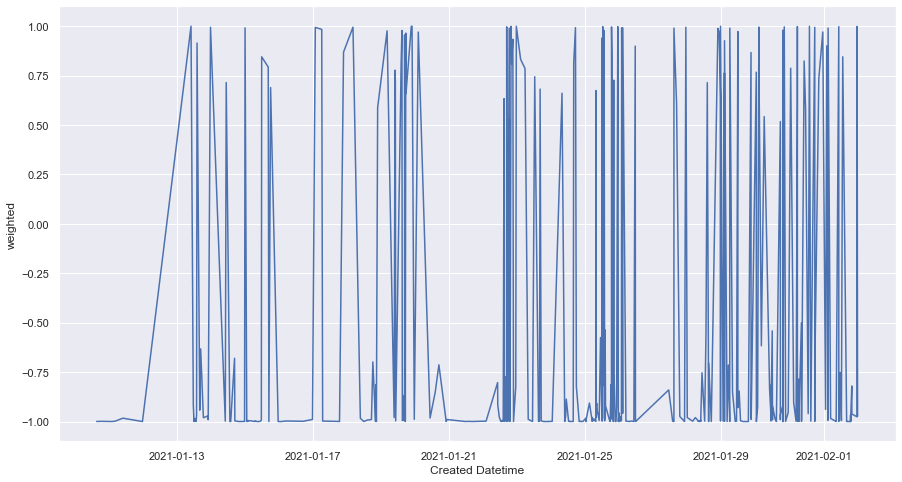

In [95]:


#sns.lineplot(x = "Created Datetime", y = "weighted", data = date_post)
#plt.show()

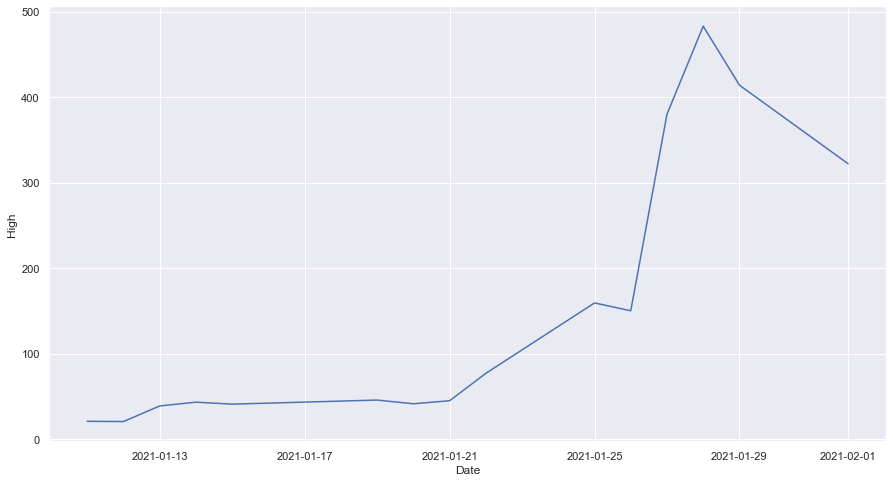

In [97]:

#sns.lineplot(x = "Date", y = "High", data = gme_stock)
#plt.show()

## I need to group the reddit data sentiments by 60 minute time intervals and then average everything in those time intervals then plot it

None


In [98]:
df=date_post.resample('1d', on='Created Datetime').weighted.mean()
#s=pd.Series(df).to_frame
s=df.keys()
i=0
gdata={}
for time in s:
    gdata[time]=df[i]
    i+=1
data=pd.DataFrame.from_dict(gdata,orient='index')
data.reset_index(inplace=True)
data.columns.values[0] = "Created Datetime"
data.columns.values[1]="avg_sentiment"
data

,Created Datetime,avg_sentiment
0,2021-01-10,-0.999319
1,2021-01-11,-0.995360
2,2021-01-12,NaN
3,2021-01-13,-0.634958
4,2021-01-14,-0.663888
5,2021-01-15,-0.617957
6,2021-01-16,-0.996368
7,2021-01-17,-0.025098
8,2021-01-18,-0.680006
9,2021-01-19,-0.086624


In [107]:
df_merge=pd.merge(gme_stock,data,how="inner",left_on='Date',right_on='Created Datetime')
df_merge

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Created Datetime,avg_sentiment
0,2021-01-11,19.410000,20.650000,19.010000,19.940001,14908000,0,0,2021-01-11,-0.995360
1,2021-01-12,19.959999,20.400000,19.320000,19.950001,7060700,0,0,2021-01-12,NaN
2,2021-01-13,20.420000,38.650002,20.030001,31.400000,144501700,0,0,2021-01-13,-0.634958
3,2021-01-14,38.090000,43.060001,33.049999,39.910000,93717400,0,0,2021-01-14,-0.663888
4,2021-01-15,38.490002,40.750000,34.009998,35.500000,46866400,0,0,2021-01-15,-0.617957
5,2021-01-19,41.549999,45.520000,36.639999,39.360001,74721900,0,0,2021-01-19,-0.086624
6,2021-01-20,37.369999,41.189999,36.060001,39.119999,33471800,0,0,2021-01-20,-0.594410
7,2021-01-21,39.230000,44.750000,37.000000,43.029999,56216900,0,0,2021-01-21,-0.999501
8,2021-01-22,42.590000,76.760002,42.320000,65.010002,197157900,0,0,2021-01-22,-0.480886
9,2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000,0,0,2021-01-25,-0.588817


In [108]:
xaxis=df_merge['Date']
yaxis1=df_merge['High']
yaxis2=df_merge['avg_sentiment']

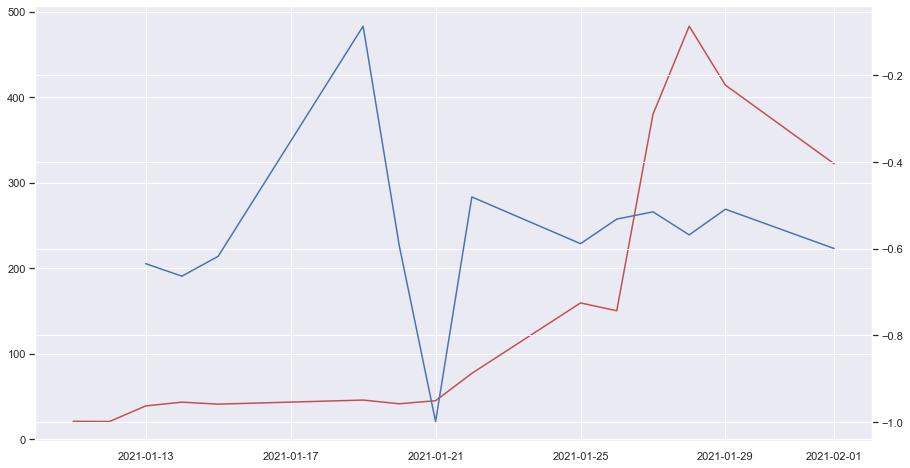

In [109]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
curve1=ax1.plot(xaxis,yaxis1,label='stock price',color='r')
curve2=ax2.plot(xaxis,yaxis2,label='avg sentiment',color='b')
plt.plot()
plt.show()

## how can i weight the sentiments so that they take into account the number of posts that those sentiments represent? I could try using a different sentiment analysis functionI could try using a topic model but it may not be able to identify the posts that indicate to buy or indicate to sell